In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from loader import S2D3DSegLoader

In [2]:
data_folder="data/2d3ds_sphere/"
fold=1
max_level=5
in_ch = "rgbd"

In [3]:
testset = S2D3DSegLoader(data_folder, "test", fold=fold, sp_level=max_level, in_ch=len(in_ch))

In [4]:
rgbd = testset[0][0]
mask = testset[0][1]

In [5]:
fname = "data/2d3ds_sphere/area_5a/area_5a_0.npz"
data, labels = np.load(fname)["data"], np.load(fname)["labels"]
data.shape

(163842, 4)

In [6]:
np.unique(labels)

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14], dtype=int32)

In [7]:
path = "data/2d3ds_pano_small/area_1/rgb/camera_0004591bfdc749a88db196a5d8b345cb_office_6_frame_equirectangular_domain_rgb.png"

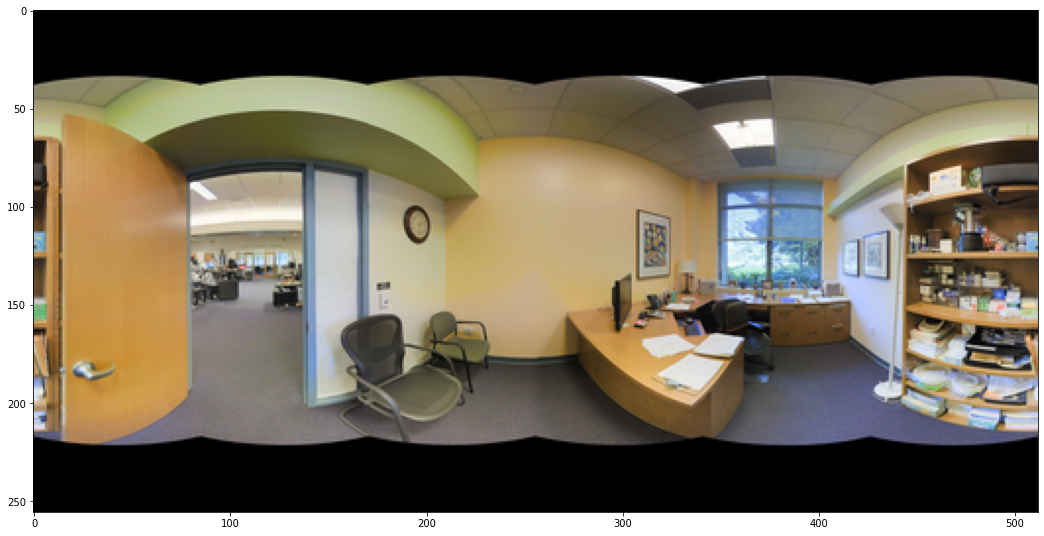

In [8]:
plt.figure(figsize=(18,12))
img = plt.imread(path)
plt.imshow(img)
plt.show()

In [8]:
!pip install imageio

     |████████████████████████████████| 3.3 MB 3.2 MB/s eta 0:00:01


In [13]:
import numpy as np
from glob import glob
import os
import random
from torch.utils.data import Dataset
from imageio import imread
    

# precomputed mean and std of the dataset
precomp_mean = [0.4974898, 0.47918808, 0.42809588, 1.0961773]
precomp_std = [0.23762763, 0.23354423, 0.23272438, 0.75536704]

class SemSegLoader(Dataset):
    """Data loader for Semantic Segmentation."""

    def __init__(self, data_dir, partition, fold, in_ch=4, normalize_mean=precomp_mean, normalize_std=precomp_std):
        """
        Args:
            data_dir: path to data directory
            partition: train or test
            fold: 1, 2 or 3 (for 3-fold cross-validation)
            
        """
        assert(partition in ["train", "test"])
        assert(fold in [1, 2, 3])
        self.in_ch = in_ch
        self.partition = partition
        self.labelmap = np.loadtxt("label_maps.txt", dtype='int32')
        if fold == 1:
            train_areas = ['1', '2', '3', '4', '6']
            test_areas = ['5a', '5b']
        elif fold == 2:
            train_areas = ['1', '3', '5a', '5b', '6']
            test_areas = ['2', '4']
        elif fold == 3:
            train_areas = ['2', '4', '5a', '5b']
            test_areas = ['1', '3', '6']

        if partition == "train":
            self.areas = train_areas
        else:
            self.areas = test_areas

        self.rgb_list = []
        self.d_list = []
        self.labels_list = []
        for a in self.areas:
            area_dir = os.path.join(data_dir, "area_" + a)
            rgb_format = os.path.join(area_dir, "rgb", "*.png")
            d_format = os.path.join(area_dir, "depth", "*.png")
            labels_format = os.path.join(area_dir, "semantic", "*.png")
            self.rgb_list += sorted(glob(rgb_format))
            self.d_list += sorted(glob(d_format))
            self.labels_list += sorted(glob(labels_format))

        self.mean = np.array(precomp_mean, dtype=np.float32)
        self.std = np.array(precomp_std, dtype=np.float32)

    def __len__(self):
        return len(self.rgb_list)

    def __getitem__(self, idx):
        # load files
        rgb = imread(self.rgb_list[idx], pilmode='RGB')/255.
        d = np.expand_dims(np.clip(imread(self.d_list[idx])/1000, 0, 5), -1)
        out_semantic = imread(self.labels_list[idx])
        out_feature_instance_id = out_semantic[..., 1].astype('uint32') * 256 + out_semantic[...,2].astype('uint32')
        out_feature_semantic_id = self.labelmap[out_feature_instance_id]

        # normalize rgbd
        rgbd = (np.concatenate((rgb, d), axis=-1) - self.mean) / self.std

        data = rgbd[..., :self.in_ch].astype(np.float32) # rgbd
        labels = out_feature_semantic_id.astype(int) # semantic labels
        # swap axes to channels x H x W
        data = np.swapaxes(np.swapaxes(data, -1, 0), 1, 2)
        labels = labels

        return data, labels

In [16]:
segloader = SemSegLoader(data_dir="data/2d3ds_pano_small/", partition="train", fold=1,)
data, label = segloader[0][0], segloader[0][1]

In [19]:
from mesh import *
s = icosphere(2)
import pyigl as igl
from iglhelpers import p2e
# visualize
v = p2e(s.vertices)
f = p2e(s.faces)
viewer = igl.glfw.Viewer()
viewer.data().set_mesh(v, f)
viewer.launch()

ModuleNotFoundError: No module named 'pyigl'